In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sun Jan 14 04:36:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 37%   65C    P2   217W / 230W |  16686MiB / 23028MiB |     82%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 42%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.trainable_sigma_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 4
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent_layer 3.814697265625e-06
decoder 6.059947967529297
decoder.linear 0.0390625
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-11/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 385784
-rw-rw-r-- 1 scpark scpark   962468  1월 14 04:36 events.out.tfevents.1705174095.GPUSVR01
-rw-rw-r-- 1 scpark scpark 38079201  1월 14 04:36 save_10000
-rw-rw-r-- 1 scpark scpark 38073393  1월 14 04:28 save_0
-rw-rw-r-- 1 scpark scpark   209828  1월 14 04:28 events.out.tfevents.1705173972.GPUSVR01
-rw-rw-r-- 1 scpark scpark  9378442  1월 14 00:21 events.out.tfevents.1705154446.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37980897  1월 14 00:16 save_90000
-rw-rw-r-- 1 scpark scpark 37980897  1월 14 00:07 save_80000
-rw-rw-r-- 1 scpark scpark 37980897  1월 13 23:59 save_70000
-rw-rw-r-- 1 scpark scpark 37980897  1월 13 23:51 save_60000
-rw-rw-r-- 1 scpark scpark 37980897  1월 13 23:42 save_50000
-rw-rw-r-- 1 scpark scpark 37980897  1월 13 23:34 save_40000
-rw-rw-r-- 1 scpark scpark 37980897  1월 13 23:26 save_30000
-rw-rw-r-- 1 scpark scpark 37980897  1월 13 23:17 save_20000
-rw-rw-r-- 1 scpark scpark  4464526  1월 13 23:00 events.out.tfevents.1705152141.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


tensor([0.2288], device='cuda:0', grad_fn=<ExpBackward0>)


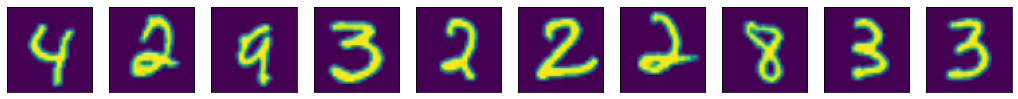

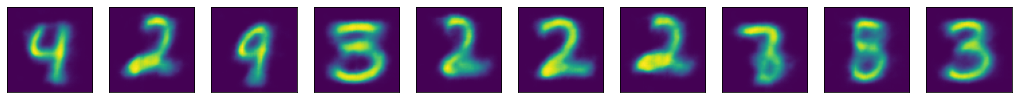

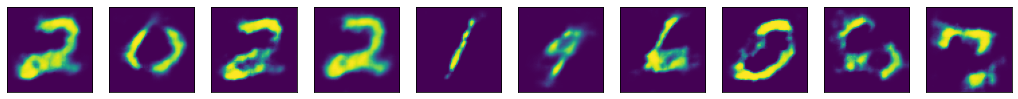

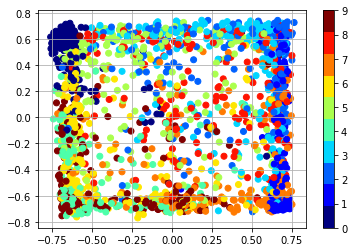

8001
lse_loss -2.408560276031494
recon_loss 0.12026582658290863
8002
lse_loss -2.342794895172119
recon_loss 0.12194077670574188
8003
lse_loss -2.2925257682800293
recon_loss 0.11932997405529022
8004
lse_loss -2.418569564819336
recon_loss 0.13375431299209595
8005
lse_loss -2.3096108436584473
recon_loss 0.12269251048564911
8006
lse_loss -2.3625850677490234
recon_loss 0.11652448028326035
8007
lse_loss -2.3675789833068848
recon_loss 0.11227986216545105
8008
lse_loss -2.4010109901428223
recon_loss 0.12442165613174438
8009
lse_loss -2.4570932388305664
recon_loss 0.12377095222473145
8010
lse_loss -2.379991054534912
recon_loss 0.11947056651115417
8011
lse_loss -2.318288803100586
recon_loss 0.1260654628276825
8012
lse_loss -2.3750414848327637
recon_loss 0.12242789566516876
8013
lse_loss -2.2843475341796875
recon_loss 0.12380561232566833
8014
lse_loss -2.37998628616333
recon_loss 0.11408460140228271
8015
lse_loss -2.420853614807129
recon_loss 0.1256038397550583
8016
lse_loss -2.3481297492980957
r

lse_loss -2.3562164306640625
recon_loss 0.11878375709056854
8132
lse_loss -2.348775863647461
recon_loss 0.12086372077465057
8133
lse_loss -2.395500659942627
recon_loss 0.1359805166721344
8134
lse_loss -2.359187126159668
recon_loss 0.10691525042057037
8135
lse_loss -2.399900436401367
recon_loss 0.12162360548973083
8136
lse_loss -2.4972286224365234
recon_loss 0.1122930496931076
8137
lse_loss -2.3387837409973145
recon_loss 0.11632832139730453
8138
lse_loss -2.4303998947143555
recon_loss 0.12610451877117157
8139
lse_loss -2.3343610763549805
recon_loss 0.12511621415615082
8140
lse_loss -2.4124321937561035
recon_loss 0.11386879533529282
8141
lse_loss -2.4243268966674805
recon_loss 0.11719128489494324
8142
lse_loss -2.351323127746582
recon_loss 0.11931252479553223
8143
lse_loss -2.4169321060180664
recon_loss 0.1180439218878746
8144
lse_loss -2.4221177101135254
recon_loss 0.12044839560985565
8145
lse_loss -2.4176135063171387
recon_loss 0.12424962967634201
8146
lse_loss -2.4134883880615234
reco

8260
lse_loss -2.3612546920776367
recon_loss 0.12645557522773743
8261
lse_loss -2.382692337036133
recon_loss 0.11856751143932343
8262
lse_loss -2.4252166748046875
recon_loss 0.10863186419010162
8263
lse_loss -2.467292308807373
recon_loss 0.126968652009964
8264
lse_loss -2.4507298469543457
recon_loss 0.12209441512823105
8265
lse_loss -2.4099507331848145
recon_loss 0.1189388856291771
8266
lse_loss -2.4378862380981445
recon_loss 0.10767459869384766
8267
lse_loss -2.4051222801208496
recon_loss 0.12189950048923492
8268
lse_loss -2.4004549980163574
recon_loss 0.12161093950271606
8269
lse_loss -2.4328532218933105
recon_loss 0.11211021989583969
8270
lse_loss -2.4232258796691895
recon_loss 0.11379502713680267
8271
lse_loss -2.396226406097412
recon_loss 0.12144976854324341
8272
lse_loss -2.374915599822998
recon_loss 0.11132382601499557
8273
lse_loss -2.4293532371520996
recon_loss 0.119029700756073
8274
lse_loss -2.436748504638672
recon_loss 0.11481928825378418
8275
lse_loss -2.4251699447631836
r

lse_loss -2.431366443634033
recon_loss 0.1124972254037857
8390
lse_loss -2.454223155975342
recon_loss 0.1282205432653427
8391
lse_loss -2.3763909339904785
recon_loss 0.11564986407756805
8392
lse_loss -2.3729162216186523
recon_loss 0.11702035367488861
8393
lse_loss -2.462362766265869
recon_loss 0.12295004725456238
8394
lse_loss -2.4340901374816895
recon_loss 0.11743154376745224
8395
lse_loss -2.408541202545166
recon_loss 0.11589372158050537
8396
lse_loss -2.3669209480285645
recon_loss 0.11490863561630249
8397
lse_loss -2.3820080757141113
recon_loss 0.12723879516124725
8398
lse_loss -2.462327480316162
recon_loss 0.11979661881923676
8399
lse_loss -2.453920364379883
recon_loss 0.11862053722143173
8400
lse_loss -2.4257941246032715
recon_loss 0.11796009540557861
8401
lse_loss -2.4181599617004395
recon_loss 0.10888729989528656
8402
lse_loss -2.3966064453125
recon_loss 0.11739315837621689
8403
lse_loss -2.396073818206787
recon_loss 0.10899486392736435
8404
lse_loss -2.37320613861084
recon_loss

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            print(torch.exp(model.latent_layer.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        